## BOAR with Transfer Matrix Method
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with transfer matrix modeling (TMM) to optimize the thickness of the layers in a multilayer stack to optimize the light utilization efficiency (LUE) of a solar cell.  
To perform the transfer matrix modeling we use a modified version of the open-source program devoloped by [McGehee's group](https://web.stanford.edu/group/mcgehee/transfermatrix/) (Stanford University) and adapted to python by Kamil Mielczarek (University of Texas).  
For more information about the transfer matrix modeling, please refer to the [original paper](https://doi.org/10.1002/adma.201000883).

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys,os
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
mat_dir = os.path.join(os.path.abspath('../'),'Example_Data/matdata') # path to the mat files directory, comment if not in Notebooks folder

In [3]:
# Initialize the agent and default device stack
layers 			= ['SiOx' , 'ITO' , 'ZnO' , 'PCE10_FOIC_1to1' , 'MoOx' , 'Ag', 'MoOx', 'LiF','MoOx', 'LiF','Air'] # list of layers (need to be the same than the name nk_*.csv file in the matdata folder)
thicknesses		= [0 , 100 , 30  , 100 , 9 , 8, 100, 100, 100, 100, 100] # list of thicknesses in nm
        
tm = Transfer_Matrix_agent(layers=layers, thicknesses=thicknesses,mat_dir=mat_dir) # initialize the agent

# Define the free parameters to be optimized

In [4]:
params = []
d_3 = Fitparam(name = 'd_3', val =  80, lims = [40, 100], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL thickness', unit = 'nm',val_type='int')
params.append(d_3)
d_4 = Fitparam(name = 'd_4', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 1 thickness', unit = 'nm',val_type='int')
params.append(d_4)
d_5 = Fitparam(name = 'd_5', val =  10, lims = [0, 15], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Ag thickness', unit = 'nm',val_type='int')
params.append(d_5)
d_6 = Fitparam(name = 'd_6', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 2 thickness', unit = 'nm',val_type='int')
params.append(d_6)
d_7 = Fitparam(name = 'd_7', val =  10, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 1 thickness', unit = 'nm',val_type='int')
params.append(d_7)  
d_8 = Fitparam(name = 'd_8', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 3 thickness', unit = 'nm',val_type='int')
params.append(d_8)
d_9 = Fitparam(name = 'd_9', val =  10, lims = [0, 200], relRange = 0, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 2 thickness', unit = 'nm',val_type='int')
params.append(d_9)
nk_3 = Fitparam(name = 'nk_3', val =  'PCE10_FOIC_1to1', lims = ['P3HTPCBM_BHJ','PCE10_FOIC_1to1','PM6Y6Brabec'], relRange = 0.5, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL nk', unit = '',val_type='str')
params.append(nk_3)

In [5]:
# run the model on the default stack configuration
X = [0] # we need to provide a list of inputs even if it is not used later

print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

Jsc =  10.53248308747983
LUE =  3.5542800166757664
AVT =  0.337458886679895


# Start the optimization

Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/4 [00:00<?, ?it/s]

Initial points done in 10.96 s
Starting with BO


BO runs:   0%|          | 0/25 [00:00<?, ?it/s]

BO done in 289.27 s
Ground truth minimum at: [67, 15, 9, 127, 142, 97, 'PCE10_FOIC_1to1'] with function value: 54.38641870460238
Minimum of surrogate function: [68, 17, 11, 137, 130, 98, 'PCE10_FOIC_1to1'] with function value 60.827301262591554


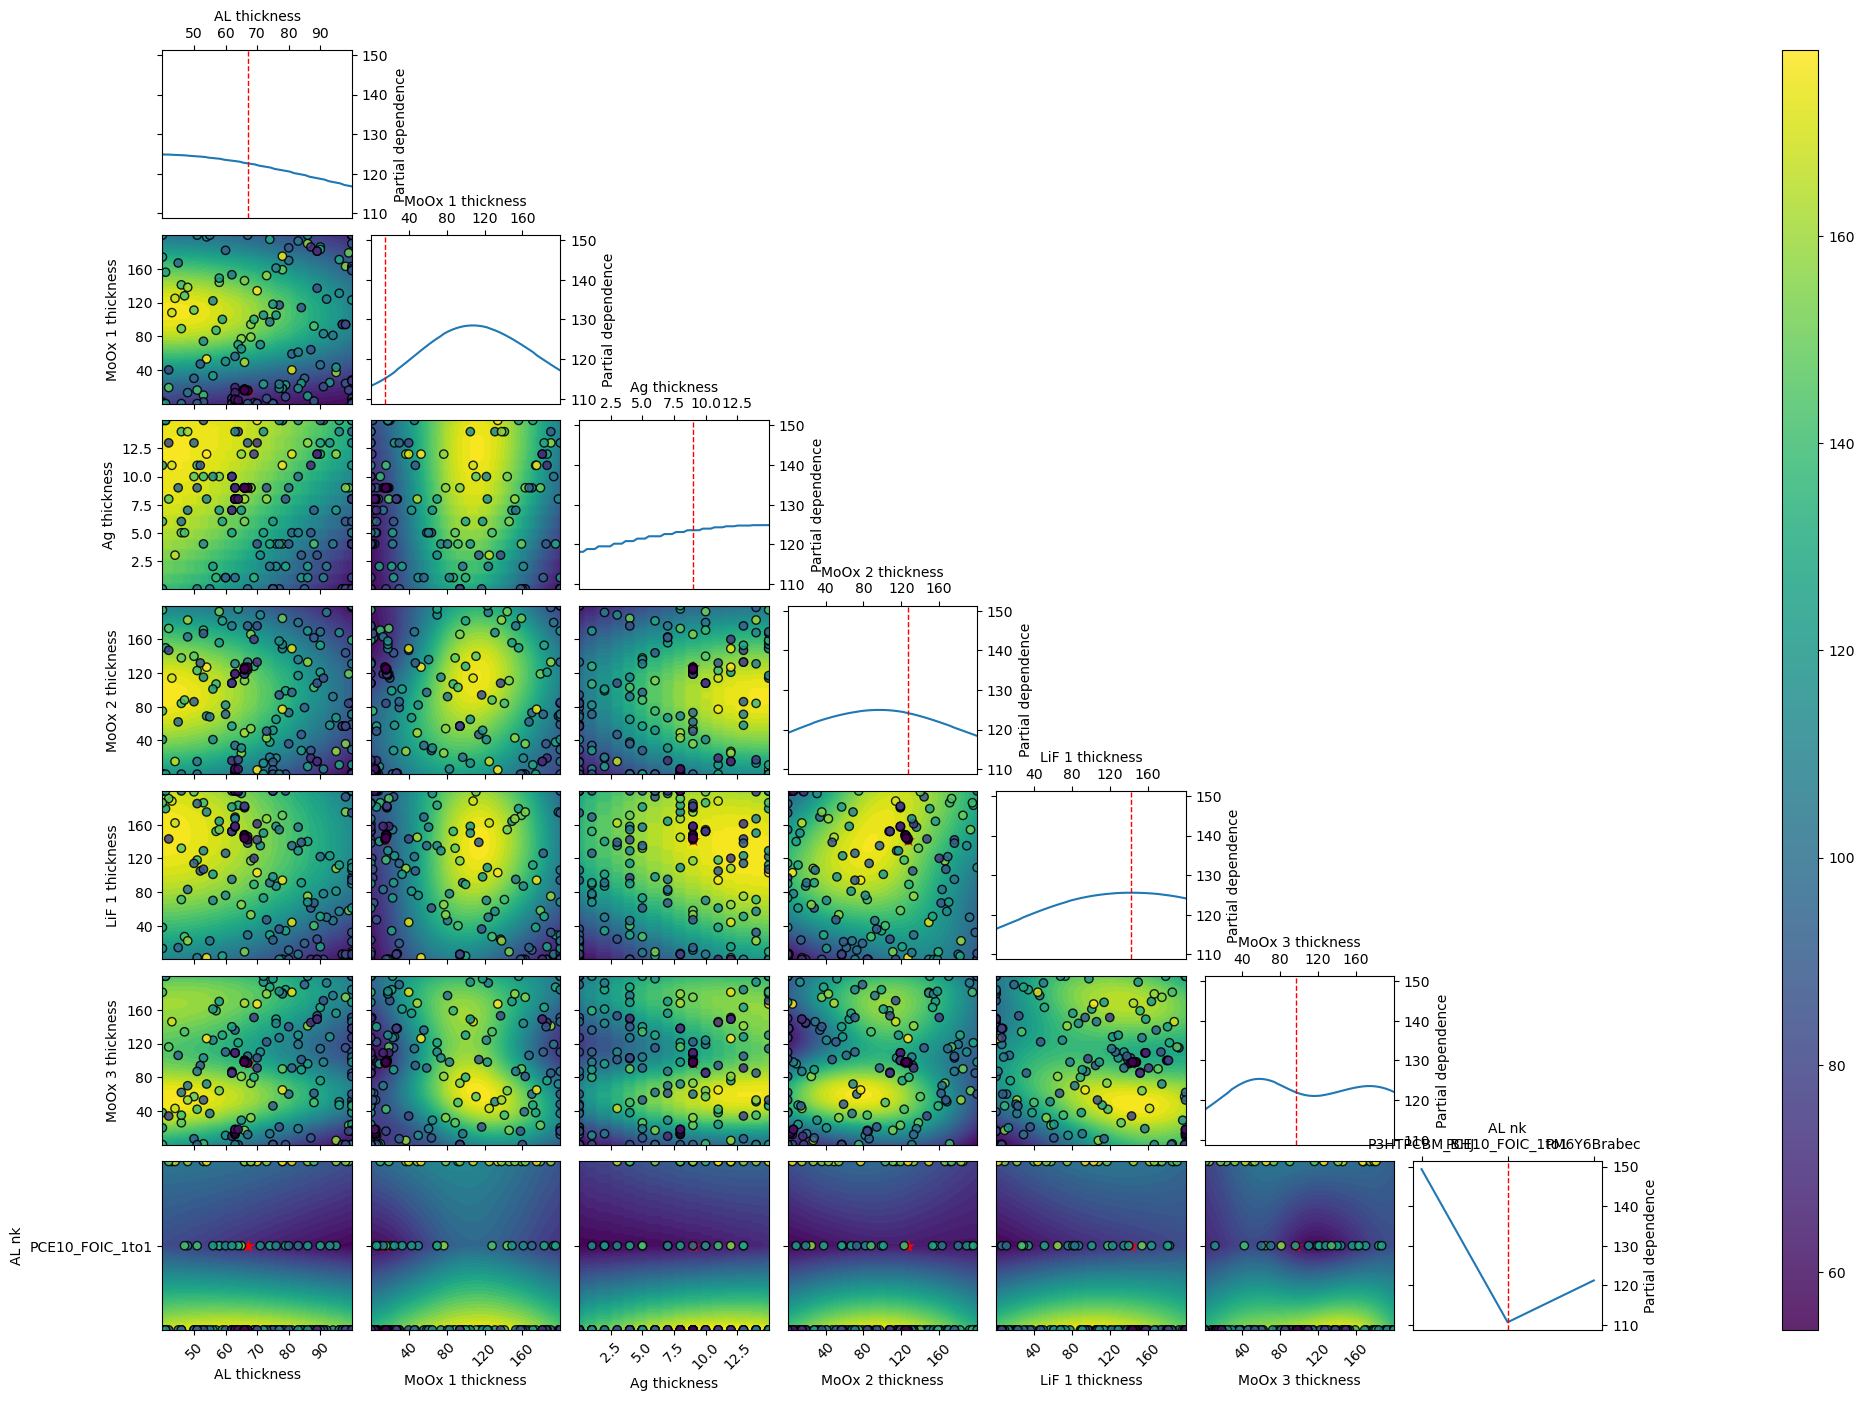

In [6]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = ''
target = {'model':partial(tm.TM,output=['LUE'],is_MOO=False),'target_name':'LUE','minimize':True,'obj_type':'diff',
          'data':{'X':X,'y':[10],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

# Define optimizer
mo = MultiObjectiveOptimizer(res_dir=res_dir,params=params,targets=[target]) # initialize the optimizer
mo.warmstart = 'none' # 'recall' data from Path2OldXY file

# Define the number of iterations for the optimization
n_jobs = 4
n_jobs_init = 20
n_yscale=20
n_initial_points = 80
n_BO = 100
n_BO_warmstart = 80

kwargs = {'check_improvement':'strict','max_loop_no_improvement':15,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':5,'gaussfilt':1,'logscale':False,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':True,'show_points':True,'savefig':True,'figname':'param_posterior' ,'show_fig':True,'figsize':(14,14)}
kwargs_plot_obj = {'zscale':'linear','show_fig':False}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=1,base_estimator = 'GP',show_objective_func=True,show_posterior=False,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj)
# pf.append(deepcopy(target['params'])) # collects optimized fitparameters
rrr = r['r'] # the results dict of the last optimizer.tell()

best_params = copy.deepcopy(mo.params) # get the best parameters



In [7]:
# Print the optimized stack structure
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} nm')
    else:
        print(p.display_name + f' {p.val}')

# Optimized performance
print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

AL thickness 67 nm
MoOx 1 thickness 15 nm
Ag thickness 9 nm
MoOx 2 thickness 127 nm
LiF 1 thickness 142 nm
MoOx 3 thickness 97 nm
LiF 2 thickness 10 nm
AL nk PCE10_FOIC_1to1
Jsc =  14.475545734390858
LUE =  7.355844164912176
AVT =  0.508156604240228
